In [1]:
import matplotlib.pyplot as plt
import pandas as pd

import seaborn as sns
import plotly
import plotly.express as px

from sklearn import preprocessing 
from sklearn.cluster import KMeans

from sklearn.cluster import DBSCAN  # импортируем DBSCAN кластеризацию

from sklearn.cluster import AgglomerativeClustering  # импортируем алгомеративную кластеризацию из sklearn

from scipy.cluster.hierarchy import dendrogram, linkage


К нам пришёл заказчик, которому необходимо проанализировать клиентов торгового центра и выделить разные группы покупателей, чтобы понять, как дальше развивать услуги торгового центра, магазины каких сегментов открывать.

В файле содержится основная информация о покупателе: идентификатор, возраст, пол, доход, индекс расходов. Индекс расходов считается на основе таких параметров, как поведение клиента и данные о покупках, и принимает значение от 1 до 100.

1. Загрузим данные

In [2]:
# загрузим данные
df = pd.read_csv("data/segmented_customers.csv")
# посмотрим на данные
df.head()

,customer_id,gender,age,annual_income,spending_score
0,1,1,19.0,15.0,39.0
1,2,1,21.0,15.0,81.0
2,3,0,20.0,16.0,6.0
3,4,0,23.0,16.0,77.0
4,5,0,31.0,17.0,40.0


2. Проведём предобработку данных: удалим пропуски и дубли, признак Gender превратим в бинарный с помощью LabelEncoder:

In [3]:
# посмотрим, есть ли пропуски в датасете
df[df.isna().any(axis=1)]

,customer_id,gender,age,annual_income,spending_score


In [4]:
# пропусков не так много, поэтому мы можем удалить данные с пропусками
df = df.dropna()

# переименуем столбцы для более удобной работы
df.rename(columns = {'CustomerID' : 'customer_id', 'Gender' : 'gender', 
                    'Age': 'age', 'Annual Income (k$)': 'annual_income', 
                    'Spending Score (1-100)': 'spending_score', }, inplace = True)

In [5]:
# проверим, есть ли в данных дубликаты
df[df.duplicated(subset=['customer_id'])]

,customer_id,gender,age,annual_income,spending_score


3. Чтобы мы могли визуально оценивать результаты кластеризации, будем проводить её по трём признакам, а именно: годовой заработок, коэффициент покупательской способности и возраст. Визуализируем распределение данных:

In [6]:
# передаём датафрейм и поля, которые нужно использовать для осей абсцисс, ординат и аппликат
fig = px.scatter_3d(
    data_frame=df, 
    x = 'age', 
    y = 'annual_income', 
    z = 'spending_score', 
    width=1000,
    height=700
)

#отображаем график
fig.show()

4. Так как нам часто будет требоваться визуализировать результаты кластеризации, напишем для этого функцию. Она будет принимать датафрейм и название столбца датафрейма с результатами кластеризации. Так как нас будут стабильно интересовать три столбца (age, annual_income, spending_score), зафиксируем их названия внутри функции:

In [7]:
def get_3d_visualization(df, clust_res):
    fig = px.scatter_3d(
        data_frame=df, 
        x = 'age', 
        y = 'annual_income', 
        z = 'spending_score', 
        color = clust_res,
        width=1000,
        height=700
    )

    #возвращаем график
    return fig

5. Сохраним признаки, по которым будем проводить моделирование, в переменную X:

In [8]:
X = df[['age', 'annual_income', 'spending_score']]

In [9]:
#запускаем кластеризацию на наших данных
# clustering = DBSCAN(eps=3, min_samples=3).fit(df[['Attack', 'Defense']])
clustering = DBSCAN().fit(X)

# Далее можно визуализировать результаты, как мы делали с алгоритмом k-means

get_3d_visualization(X, clust_res=clustering.labels_)

6. Как видно, алгоритм плохо работает с настройками по умолчанию, поэтому попробуем изменить их.

Большая часть наших данных разрежённые, а чем больше разброс точек в датасете, тем большее значение радиуса вокруг точки (eps) нужно задавать. Так как данные разрежённые, попробуем увеличить значение eps до 11 и визуально оценим результат:

In [10]:
#запускаем кластеризацию на наших данных
dbscan = DBSCAN(eps=11)
clustering_dbscan_res = dbscan.fit_predict(X)
df['dbscan_res_eps_11'] = clustering_dbscan_res

display(df['dbscan_res_eps_11'].nunique())
get_3d_visualization(df, 'dbscan_res_eps_11')


6

7. Проведём агломеративную кластеризацию, чтобы построить дендрограмму и по ней оценить количество кластеров, на которое можно разделить датасет. Напишем функцию, которая будет принимать количество кластеров и матрицу с признаками:

In [11]:
def get_aggl_clustering(X, n_clusters):
    ''' Функция проводит алгомеративную кластеризацию
        на вход принимает X — матрицу с признаками для кластеризации 
        и n_clusters — количество кластеров, на выходе список с номерами кластеров'''
        
    # запустим агломеративную кластеризацию
    agglomerative_clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    # обучим модель агломеративной кластеризации
    agglomerative_clustering.fit(X)
    # получим список c информацией, к какому кластеру относятся объекты
    aggl_prediction = agglomerative_clustering.labels_
    # вернём список с результатами
    return aggl_prediction

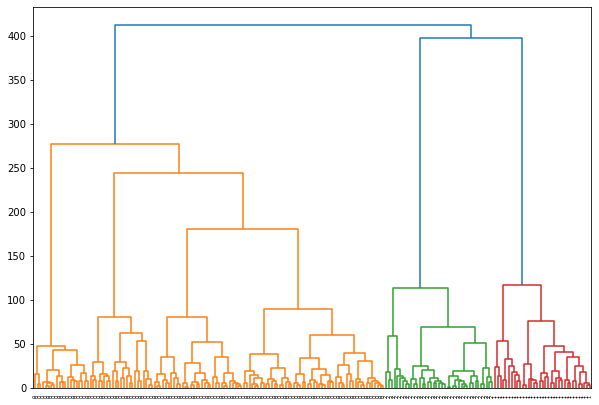

In [12]:
# запускаем агломеративную кластеризацию и сохраним результаты в df
df['aggl_res_3'] = get_aggl_clustering(X, 3)

linked = linkage(X, 'ward')  # расссчитаем расстояния между кластерами
plt.figure(figsize=(10, 7))

# визуализируем дендрограмму с ориентацией top
# сначала будут отрисовываться кластеры с минимальным расстоянием между друг другом
dendrogram(linked,
            orientation='top',
            labels=df['aggl_res_3'].to_list(),
            distance_sort='descending',
            show_leaf_counts=True)

plt.show()

Если взять евклидово расстояние между кластерами, равное 150, датасет будет делиться на шесть кластеров.

Давайте визуально оценим, что из этого получилось. Для этого обучим модель агломеративной кластеризации с количеством кластеров, равным 6:

In [13]:
# from mpl_toolkits.mplot3d import Axes3D
df['aggl_res_6'] = get_aggl_clustering(df[['age', 'annual_income', 'spending_score']], n_clusters=6)
get_3d_visualization(df, 'aggl_res_6')

<AxesSubplot:xlabel='cluster', ylabel='silhouette'>

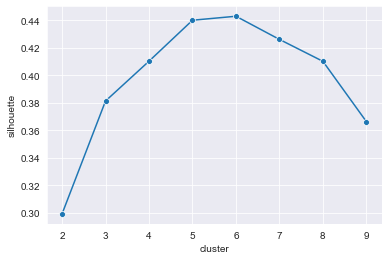

In [14]:
from sklearn.metrics import silhouette_score


# напишем функцию для подсчёта коэффициента силуэта
def get_silhouette_agg_clust(X, cluster_num):
    # проведём агломеративную кластеризацию с заданным количеством кластеров
    res = get_aggl_clustering(X, cluster_num)
    # рассчитаем коэффициент силуэта
    silhouette = silhouette_score(X, res)
    return silhouette


# создадим пустой словарь, ключами будут коэффициент силуэта и количество кластеров
silhouette_res = {"silhouette": [], "cluster": []}


for cluster_num in range(2, 10):
    silhouette_res["silhouette"].append(get_silhouette_agg_clust(X, cluster_num))
    silhouette_res["cluster"].append(cluster_num)

# сохраним в датафрейм значение силуэта и количество кластеров
silhouette_df = pd.DataFrame(silhouette_res)

# установим стиль для визуализиции
sns.set_style("darkgrid")
# визуализируем зависимость значения инерции от количества кластеров
sns.lineplot(data=silhouette_df, x="cluster", y="silhouette", marker="o")

Как видим, пик коэффициента силуэта находится на значении 6. Таким образом, оптимальное количество кластеров — 6.

9. Теперь рассмотрим столбец cluster: в нём есть информация о том, к какому кластеру должен принадлежать каждый объект из датасета. Значит, мы можем проверить качество кластеризации, посчитав различные метрики.

Метрику полноты можно вызвать из модуля cluster библиотеки sklearn. Метрика рассчитывается следующим образом:

In [20]:
from sklearn.metrics.cluster import completeness_score

print(completeness_score(labels_true=df.cluster, labels_pred=df.aggl_res_6))

AttributeError: 'DataFrame' object has no attribute 'cluster'